In [1]:
%load_ext autoreload
%autoreload 2

## Imports and data loading

In [186]:
from toai_ml_toolkit.imports import *
from toai_ml_toolkit.transformers import *
from toai_ml_toolkit.graphs import *
from sklearn.model_selection import TimeSeriesSplit

In [3]:
DATA_DIR = Path('data')
TEMP_DIR = Path('tmp')

In [130]:
df = pd.read_csv(DATA_DIR/'weatherAUS.csv', low_memory=False, parse_dates=['Date'])

### Data splitting and cleanup

Since we have a time series data and location based data we need to group them by Location and only then take data from each group for train/val/test data sets

In [94]:
def split_df(data, test_size):
    train_data = pd.DataFrame(columns=data.columns)
    test_data = pd.DataFrame(columns=data.columns)
    val_data = pd.DataFrame(columns=data.columns)
    
    temp_data = pd.DataFrame(columns=data.columns)
    gb = data.groupby('Location')    
    groups = [gb.get_group(x) for x in gb.groups]
    for group in groups:
        t_len = int((len(group) * test_size))
        temp_data = temp_data.append(group[-t_len:])
        train_data = train_data.append(group[:-t_len])
    
    gb = temp_data.groupby('Location')    
    groups = [gb.get_group(x) for x in gb.groups]
    for group in groups:
        g_len = int((len(group) * 0.5))
        val_data = val_data.append(group[:g_len])
        test_data = test_data.append(group[g_len:])
    
    for df in train_data, val_data, test_data:
        df.reset_index(drop=True, inplace=True)
    
    return train_data, val_data, test_data

Data param class for easier data managemet

In [188]:
class DataParams:
    def __init__(self, target, categorical=None, continuous=None):
        self.target = target
        self.features = categorical + continuous
        self.categorical = categorical
        self.continuous = continuous

Rudimentary data cleanum before preprocessing. Replacing labels `Yes`, `No` with 0 and 1

In [131]:
df.replace({'RainToday': {'Yes': 1, 'No': 0}}, inplace=True)
df.replace({'RainTomorrow': {'Yes': 1, 'No': 0}}, inplace=True)
df['RainToday'].fillna(0, inplace=True)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
Date             142193 non-null datetime64[ns]
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        142193 non-n

In [133]:
data_params = DataParams(
    target='RainTomorrow',
    categorical=[
        "Location",
        "WindGustDir",
        "WindDir9am",
        "WindDir3pm",
        "RainToday",
    ],
    continuous=[
        "MinTemp",
        "MaxTemp",
        "Rainfall",
        "Evaporation",
        "Sunshine",
        "WindGustSpeed",
        "WindSpeed9am",
        "WindSpeed3pm",
        "Humidity9am",
        "Humidity3pm",
        "Pressure9am",
        "Pressure3pm",
        "Cloud9am",
        "Cloud3pm",
        "Temp9am",
        "Temp3pm",
        "RISK_MM"
    ],
)

In [225]:
train_data, val_data, test_data = split_df(df, 0.4)

In [159]:
[x.shape for x in (train_data, val_data, test_data)]

[(85334, 24), (28417, 24), (28442, 24)]

In [138]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85334 entries, 0 to 85333
Data columns (total 24 columns):
Date             85334 non-null datetime64[ns]
Location         85334 non-null object
MinTemp          84926 non-null float64
MaxTemp          85152 non-null float64
Rainfall         84562 non-null float64
Evaporation      53832 non-null float64
Sunshine         50481 non-null float64
WindGustDir      79375 non-null object
WindGustSpeed    79414 non-null float64
WindDir9am       79250 non-null object
WindDir3pm       83714 non-null object
WindSpeed9am     84473 non-null float64
WindSpeed3pm     84469 non-null float64
Humidity9am      84123 non-null float64
Humidity3pm      84138 non-null float64
Pressure9am      77629 non-null float64
Pressure3pm      77662 non-null float64
Cloud9am         54361 non-null float64
Cloud3pm         53333 non-null float64
Temp9am          84592 non-null float64
Temp3pm          84642 non-null float64
RainToday        85334 non-null float64
RISK_MM 

### RF and NN model data preprocessing pipeline

In [160]:
cat_pipeline = Pipeline([
    ('imputer', CategoricalInputer()),
    ('encoder', CategoricalEncoder()),
])

In [161]:
num_pipeline = Pipeline([
    ('imputer', NumericInputer()),
    ('polynomial_features', PolynomialFeatures()),
    ('scaler', RobustScaler()),
])

In [162]:
preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, data_params.continuous),
    ("cat", cat_pipeline, data_params.categorical),
])

In [163]:
train_labels = train_data[data_params.target].astype(int)
prep_train_data = preprocess_pipeline.fit_transform(train_data[data_params.features])
val_labels = val_data[data_params.target].astype(int)
prep_val_data = preprocess_pipeline.transform(val_data[data_params.features])

## RFC Model

In [143]:
rfc = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=5,
    n_jobs=-1
)

In [164]:
rfc.fit(prep_train_data, train_labels.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [165]:
rfc_predictions = rfc.predict(prep_val_data)

In [166]:
print(classification_report(val_labels.values.astype(int), rfc_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22096
           1       1.00      1.00      1.00      6321

    accuracy                           1.00     28417
   macro avg       1.00      1.00      1.00     28417
weighted avg       1.00      1.00      1.00     28417



Insane accuracy!!!

## NN Model

In [167]:
def make_model(input_shape, layer_size, dropout_rate=0.0, n_layers=1, regularization=None, batch_norm=True):
    layers = [
        keras.layers.InputLayer(input_shape=input_shape)
      ]
  
    for _ in range(n_layers):
        if batch_norm:
            layers += [keras.layers.BatchNormalization()]
    
        layers += [
            keras.layers.Dense(
                layer_size,
                kernel_initializer="he_uniform",
                kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
            ),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(dropout_rate)
        ]
    
    layers += [keras.layers.Dense(1, activation="sigmoid")]
  
    return keras.Sequential(layers)

In [168]:
nn_model = make_model(
    input_shape=prep_train_data.shape[1:],
    layer_size=64, 
    dropout_rate=0.2, 
    n_layers=1, 
    regularization=(1e-5, 1e-4), 
    batch_norm=True,
)

In [169]:
nn_model.compile(
    optimizer = keras.optimizers.Adam(lr=1e-3),
    loss = keras.losses.binary_crossentropy,
    metrics = [
        keras.metrics.binary_accuracy
    ]
)

In [170]:
PATIENCE = 10

nn_model_history = nn_model.fit(
    prep_train_data,
    train_labels.values,
    batch_size=32,
    validation_data=(prep_val_data,val_labels),
    epochs=100,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'nn_model.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True),
        keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR/'nn_model_logs')),
    ]
)

W0808 13:00:47.021396 4592686528 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 85334 samples, validate on 28417 samples
Epoch 1/100
85334/85334 [==============================] - 5s 55us/sample - loss: 0.2177 - binary_accuracy: 0.9272 - val_loss: 0.1707 - val_binary_accuracy: 0.9477
Epoch 2/100
85334/85334 [==============================] - 4s 49us/sample - loss: 0.1474 - binary_accuracy: 0.9567 - val_loss: 0.1412 - val_binary_accuracy: 0.9662
Epoch 3/100
85334/85334 [==============================] - 4s 47us/sample - loss: 0.1336 - binary_accuracy: 0.9609 - val_loss: 0.1377 - val_binary_accuracy: 0.9655
Epoch 4/100
85334/85334 [==============================] - 4s 48us/sample - loss: 0.1333 - binary_accuracy: 0.9604 - val_loss: 0.1279 - val_binary_accuracy: 0.97425 - binary_accuracy: 0. - ETA: 0s - loss: 0.1308 - bina
Epoch 5/100
85334/85334 [==============================] - 4s 47us/sample - loss: 0.1252 - binary_accuracy: 0.9640 - val_loss: 0.1162 - val_binary_accuracy: 0.9750
Epoch 6/100
85334/85334 [==============================] - 4s 48us/sample -

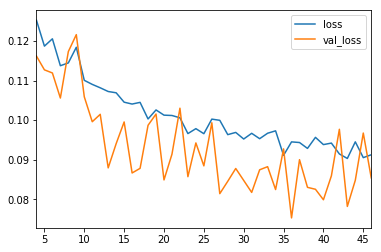

In [172]:
plot_history(nn_model_history, 'loss', 4)

In [490]:
nn_model.evaluate(preprocess_pipeline.transform(test_data[data_params.features]), test_data[data_params.target])

42658/42658 [==============================] - 1s 18us/sample - loss: 0.0674 - binary_accuracy: 0.9804


[0.06736426367432506, 0.9803788]

In [173]:
test_probabilities = nn_model.predict(preprocess_pipeline.transform(test_data[data_params.features]))

In [174]:
treshold = 0.5
test_preds = (test_probabilities >= treshold)

In [181]:
print(confusion_matrix(test_data[data_params.target].astype(int), test_preds))

[[21997    41]
 [  628  5776]]


In [182]:
print(classification_report(test_data[data_params.target].astype(int), test_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     22038
           1       0.99      0.90      0.95      6404

    accuracy                           0.98     28442
   macro avg       0.98      0.95      0.97     28442
weighted avg       0.98      0.98      0.98     28442



Although not as good as RF but also great result!

## Preprocessing for Embedded model

Need to create separate pipelines for Embedded models to retain column names for easier dimensions extraction.

In [326]:
cat_pipeline = Pipeline([
    ('imputer', CategoricalInputer(data_params.categorical)),
    ('encoder', CategoricalEncoder(data_params.categorical)),
])

In [327]:
num_pipeline = Pipeline([
    ('imputer', NumericInputer()),
    ('polynomial_features', PolynomialFeatures()),
    ('scaler', RobustScaler()),
])

In [328]:
preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, data_params.continuous),
    ("cat", cat_pipeline, data_params.categorical),
])

In [329]:
cat_prep_train_data = cat_pipeline.fit_transform(train_data[data_params.categorical])
con_prep_train_data = num_pipeline.fit_transform(train_data[data_params.continuous])
cat_prep_val_data = cat_pipeline.transform(val_data[data_params.categorical])
con_prep_val_data = num_pipeline.transform(val_data[data_params.continuous])

In [330]:
cat_feature_dims = {cat_col: len(np.unique(
    cat_prep_train_data[cat_prep_train_data.columns])) + 2 for cat_col in cat_prep_train_data.columns}
cat_feature_dims

{'Location': 52,
 'Location_na': 52,
 'WindGustDir': 52,
 'WindGustDir_na': 52,
 'WindDir9am': 52,
 'WindDir9am_na': 52,
 'WindDir3pm': 52,
 'WindDir3pm_na': 52,
 'RainToday': 52,
 'RainToday_na': 52}

In [441]:
prep_train_data = np.concatenate((cat_prep_train_data.values, con_prep_train_data), axis=1)
prep_val_data = np.concatenate((cat_prep_val_data.values, con_prep_val_data), axis=1)

### Creating embedding model

In [403]:
def make_embedding_model(
    cat_feature_dims,
    n_cont_features,
    layer_size=256,
    dropout_rate=0.0,
    l2_regularization=1e-8,
    n_layers=1,
):

    inputs = []
    embeddings = []
    for cat_feature_dim in cat_feature_dims.values():
        x = tf.keras.layers.Input(shape=(1,))
        inputs.append(x)
        x = tf.keras.layers.Embedding(
            cat_feature_dim, np.sqrt(cat_feature_dim).astype(int) + 1, input_length=1
        )(x)
        x = tf.keras.layers.Flatten()(x)
        embeddings.append(x)

    cont_inputs = tf.keras.layers.Input(shape=(n_cont_features,))
    inputs.append(cont_inputs)
    embeddings.append(cont_inputs)

    x = tf.keras.layers.Concatenate()(embeddings)

    for _ in range(n_layers):
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Dense(
            layer_size,
            kernel_initializer="he_uniform",
            kernel_regularizer=tf.keras.regularizers.l2(l2_regularization),
        )(x)
        x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Dense(2, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

In [404]:
nn_embedded_model = make_embedding_model(
    cat_feature_dims = cat_feature_dims,
    n_cont_features = len(con_prep_train_data),
    layer_size=256,
    dropout_rate=0.1,
    l2_regularization=1e-8,
    n_layers=3,
)

10


In [405]:
nn_embedded_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[
        tf.keras.metrics.binary_accuracy,
    ]
)

In [425]:
nn_embedded_model.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_275 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_276 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_277 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_278 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

In [436]:
df_train_cat = pd.DataFrame(cat_prep_train_data.values)
df_val_cat = pd.DataFrame(cat_prep_val_data.values)
df_train_cont = pd.DataFrame(con_prep_train_data)
df_val_cont = pd.DataFrame(con_prep_val_data)

In [438]:
emb_train_data = [df_train_cat[x] for x in df_train_cat] + [df_train_cont]
emb_val_data = [df_val_cat[x] for x in df_val_cat] + [df_val_cont]

### Train embedding model

In [442]:
PATIENCE = 10

nn_embedded_model_history = nn_embedded_model.fit(
    prep_train_data,
    train_data[data_params.target].values,
    validation_data=(emb_val_data,val_data[data_params.target].values),
    batch_size=32,
    epochs=100,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'nn_model.h5'), save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(patience=PATIENCE * 3, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=str(TEMP_DIR/'logs')),
    ],
)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 11 array(s), but instead got the following list of 1 arrays: [array([[ 1.,  0.,  8., ...,  1.,  0.,  0.],
       [ 1.,  0., 13., ...,  0.,  0.,  0.],
       [ 1.,  0., 14., ...,  0.,  0.,  0.],
       ...,
       [49.,  0., 11., ...,  0.,  0.,  0.],
       [49....

In [ ]:
evaluate_pipeline(
    pipeline=nn_model,
    datasets=[[train_data, train_labels], [val_data, val_labels]],
    label_pipeline=label_pipeline,
    preprocess_pipeline=preprocess_pipeline,
    metrics=[mean_absolute_error, mean_squared_error, explained_variance_score],
)